In [1]:
import yaml
import random
import numpy as np
import time

from reader import Reader

from const import Const
from utils import get_F_example
from clustering import Clusters
from fastclustering import Fast_Clusters
from i_merge import IMerger
from Subclusterring import Subclusters

from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd

# Если есть желание создать свои данные, то вызвать этот код

In [2]:
# X, y = make_blobs(n_samples=200, centers=7, cluster_std=0.6, random_state=0)

# ids = [i+1 for i in range(len(X))]
# df = pd.DataFrame()
# df['id'] = ids
# df['X1'] = X[:,0]
# df['X2'] = X[:,1]

In [3]:
# ids = []
# X1 = []
# X2 = []
# with open('Two.txt', 'r') as f:
#     for k, line in enumerate(f):
#         if k==0:
#             continue
#         ids.append(int(line.split()[0]))
#         X1.append(float(line.split()[1]))
#         X2.append(float(line.split()[2]))
#         if k>=205:
#             break
# df = pd.DataFrame()
# df['id'] = ids
# df['X1'] = X1
# df['X2'] = X2
    

In [4]:
reader = Reader()

In [65]:
df = reader.read('./Data/5D.xlsx')

Stated size of data 500
Data contained  0 incorrect rows
Size of data 500
X1 contain 1434 zero distances 0.00574
Interval: 0.023477530746534116
Interval: 0.08428588577579789
Interval: 0.15299088050915693
Interval: 0.2252783206195862
Interval: 0.3017604409786687
Interval: 0.3829939315747405
Interval: 0.47198392051397015
Interval: 0.5788545038742483
Interval: 0.7067583222882047
Interval: 0.9619352158396215
histogram [63420 52116 45842 36346 26196 14938  6320  3132  1426   264]
bins lenght [0.         0.15575643 0.31151286 0.46726929 0.62302572 0.77878215
 0.93453858 1.09029501 1.24605144 1.40180787 1.5575643 ]
X2 contain 1434 zero distances 0.00574
Interval: 0.08654977750238319
Interval: 0.31329181614885143
Interval: 0.5611397056599189
Interval: 0.8381047708324938
Interval: 1.1523482782368664
Interval: 1.459894544350266
Interval: 1.8002468721267997
Interval: 2.2103222517341843
Interval: 2.737417146366575
Interval: 3.423461931858441
histogram [52348 40964 35626 34184 27620 21150 19378 130

In [66]:
df, df_test = reader.split_data(df, train_size=99)

In [67]:
df.shape

(495, 6)

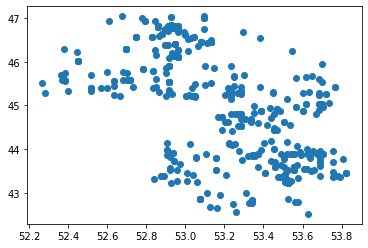

In [68]:
plt.scatter(df['X1'], df['X2'])
plt.show()

# Подбор констант

In [69]:
const = Const()

C:\Users\zheny\Documents\clusters\const.py:15: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  self.config = yaml.load(open("settings.yaml", 'r'))


In [70]:
const.norm(df) # Нормировка

Persent of zeros start: 0.014396490154065912 for X 0
Persent of zeros finish: 0.004999489847974697 for X 0
Persent of zeros start: 0.014396490154065912 for X 1
Persent of zeros finish: 0.004999489847974697 for X 1
Persent of zeros start: 0.48232833384348534 for X 2
Persent of zeros finish: 0.004999489847974697 for X 2
Persent of zeros start: 0.027150290786654423 for X 3
Persent of zeros finish: 0.004999489847974697 for X 3
Persent of zeros start: 0.17891031527395163 for X 4
Persent of zeros finish: 0.004999489847974697 for X 4


In [71]:
const.get_norms() # Получение норм

{'X1': 0.1234807522221024,
 'X2': 0.459726005232921,
 'X3': 62.89879155188309,
 'X4': 27.41558412406897,
 'X5': 17.591519028670543}

In [72]:
a = time.time()
const.calculate_a(df, type_of_optimization=4) # Вычисление а и пересчет констант
b = time.time()
print(b-a)

Persent of zeros start: 0.0
going up
40.158358097076416


In [73]:
const.add_Fcolumn(df)

In [74]:
const.config # Вывод параметров

{'conturs': {'min_points': 30,
  'contour_points': 50,
  'min_diff': 0.0,
  'num_of_lenghts': 4},
 'isolated_cluster': {'constU1': 0.05,
  'min_len': 1.01,
  'min_dif': 0.0,
  'divider': 2,
  'max_div_num': 8,
  'merge_threshold': 1.75},
 'subcluster': {'F_step': 0.001},
 'knots': {'min_fuses_num': 15, 'stop_const': 2.02},
 'consts': {'percent_for_norms': 40,
  'percent_of_zeros': 0.005,
  'round_const': 2,
  'const': 0.25,
  'percent_X': 5,
  'down_steps': 4,
  'up_steps': 6,
  'max_depth': 10,
  'power_koef': 1.16,
  'percent_Y': 33,
  'threshold': 0.8,
  'Y_step': 2.5,
  'a': 2.02}}

In [41]:
const.config

{'conturs': {'min_points': 30,
  'contour_points': 50,
  'min_diff': 0.17,
  'num_of_lenghts': 4},
 'isolated_cluster': {'constU1': 0.05,
  'min_len': 1e-10,
  'min_dif': 1e-10,
  'divider': 1,
  'max_div_num': 8,
  'merge_threshold': 1.75},
 'subcluster': {'F_step': 0.001},
 'knots': {'min_fuses_num': 15, 'stop_const': 0.1},
 'consts': {'percent_for_norms': 40,
  'percent_of_zeros': 0.005,
  'round_const': 2,
  'const': 0.25,
  'percent_X': 5,
  'down_steps': 4,
  'up_steps': 6,
  'max_depth': 10,
  'power_koef': 1.16,
  'percent_Y': 33,
  'threshold': 0.8,
  'Y_step': 2.5,
  'a': 0.1}}

In [42]:
const.save_consts('example1') #Сохранение констант в файл

Writing settings in file example1 .yaml


Researching dataset

In [43]:
# fig = px.scatter_3d(df, x='X1', y='X2', z='F')
# fig.show()

# Fast Кластеризация

In [75]:
fastcluster = Fast_Clusters(const.config) 

In [76]:
df = fastcluster.get_isolated_clusters(df) # Вычисление кластеров
df.head()

100%|████████████████████████████████████████████████████████████████████████████████| 495/495 [00:05<00:00, 86.53it/s]


,id,X1,X2,X3,X4,X5,F,cluster_id
0,1,434.301480,92.475753,7.835445,1.666935,5.570866,0.006144,7
1,2,435.430157,98.785012,26.465373,9.118901,11.937571,0.032574,1
2,3,433.888151,93.091659,17.948835,3.465182,9.947975,0.014485,4
3,4,434.749359,99.219386,21.297071,8.279962,7.503616,0.018581,2
4,5,434.798335,95.630316,5.151132,0.350166,10.232203,0.006561,6


In [77]:
len(set(df['cluster_id']))

10

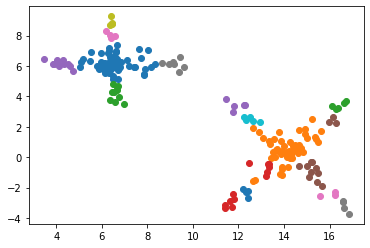

In [47]:
for cluster in set(df['cluster_id']):
    plt.scatter(df[df['cluster_id']==cluster]['X1'], df[df['cluster_id']==cluster]['X2'])

# Кластеризация

In [53]:
cluster = Clusters(const.config) 

In [54]:
df = cluster.get_isolated_clusters(df) # Вычисление кластеров
df.head()

100%|████████████████████████████████████████████████████████████████████████████████| 203/203 [00:24<00:00,  8.17it/s]


,id,X1,X2,F,cluster_id
0,1,6.573505,3.637345,0.021968,0
1,2,6.758528,3.988122,0.025881,0
2,3,6.432392,4.307272,0.032710,0
3,4,6.546103,4.321220,0.035108,0
4,5,6.732023,4.655845,0.038217,0


In [55]:
const.config

{'conturs': {'min_points': 30,
  'contour_points': 50,
  'min_diff': 0.17,
  'num_of_lenghts': 4},
 'isolated_cluster': {'constU1': 0.05,
  'min_len': 1e-10,
  'min_dif': 1e-10,
  'divider': 1,
  'max_div_num': 8,
  'merge_threshold': 1.75},
 'subcluster': {'F_step': 0.001},
 'knots': {'min_fuses_num': 15, 'stop_const': 0.1},
 'consts': {'percent_for_norms': 40,
  'percent_of_zeros': 0.005,
  'round_const': 2,
  'const': 0.25,
  'percent_X': 5,
  'down_steps': 4,
  'up_steps': 6,
  'max_depth': 10,
  'power_koef': 1.16,
  'percent_Y': 33,
  'threshold': 0.8,
  'Y_step': 2.5,
  'a': 0.1}}

In [56]:
len(set(df['cluster_id']))

17

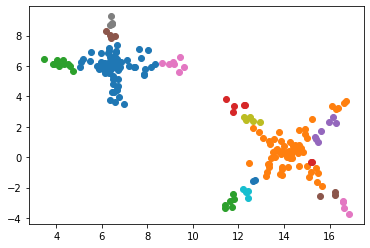

In [57]:
for cluster in set(df['cluster_id']):
    plt.scatter(df[df['cluster_id']==cluster]['X1'], df[df['cluster_id']==cluster]['X2'])


In [58]:
fig = px.scatter_3d(df, x='X1', y='X2', z='X3',
              color='cluster_id')
fig.show()

ValueError: Value of 'z' is not the name of a column in 'data_frame'. Expected one of ['id', 'X1', 'X2', 'F', 'cluster_id'] but received: X3

In [ ]:
df.head()

# Merge I

In [78]:
df

,id,X1,X2,X3,X4,X5,F,cluster_id
0,1,434.301480,92.475753,7.835445,1.666935,5.570866,0.006144,7
1,2,435.430157,98.785012,26.465373,9.118901,11.937571,0.032574,1
2,3,433.888151,93.091659,17.948835,3.465182,9.947975,0.014485,4
3,4,434.749359,99.219386,21.297071,8.279962,7.503616,0.018581,2
4,5,434.798335,95.630316,5.151132,0.350166,10.232203,0.006561,6
...,...,...,...,...,...,...,...,...
495,496,428.913861,101.533878,31.341779,3.100426,11.937571,0.089900,0
496,497,428.336950,94.355073,29.670522,6.419706,8.526836,0.051677,1
497,498,428.775925,101.751265,31.341779,3.647560,13.813475,0.075723,0
498,499,427.934011,94.209663,30.500427,5.726670,6.821469,0.038093,1


In [79]:
Merger = IMerger(const.config)
Merger.mergeClusters(df)

In [80]:
set(df['cluster_id'])

{0, 3, 5, 6, 7, 9}

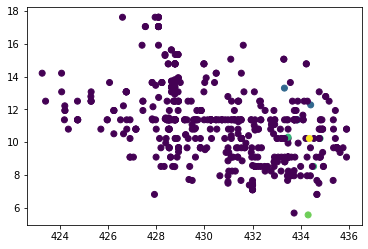

In [85]:
plt.scatter(df['X1'],df['X5'], c=df['cluster_id'])

In [52]:
fig = px.scatter_3d(df, x='X1', y='X2', z='X3',
              color='cluster_id')
fig.show()

ValueError: Value of 'z' is not the name of a column in 'data_frame'. Expected one of ['id', 'X1', 'X2', 'F', 'cluster_id'] but received: X3

# Subcluster

In [89]:
const.config['subcluster']['F_step'] = 0.1

In [90]:
sub = Subclusters(const.config)

In [91]:
df = sub.subclustering(df, type_of_closed=2)

  1%|█                                                                                 | 6/486 [00:00<00:10, 45.22it/s]

Calculate for  6 clusters


100%|██████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 3008.83it/s]


In [ ]:
fig = px.scatter(df, x="X1", y="X2", color="subcluster_id", hover_data=['id', 'F'], )
fig.show()

In [ ]:
fig = px.scatter_3d(df, x='X1', y='X2', z='X3',
              color='subcluster_id')
fig.show()

# Last Stage

In [93]:
df[df['cluster_id']==7]

,id,X1,X2,X3,X4,X5,F,cluster_id,subcluster_id
0,1,434.30148,92.475753,7.835445,1.666935,5.570866,0.006144,7,None


In [92]:
df.head()

,id,X1,X2,X3,X4,X5,F,cluster_id,subcluster_id
0,1,434.301480,92.475753,7.835445,1.666935,5.570866,0.006144,7,None
1,2,435.430157,98.785012,26.465373,9.118901,11.937571,0.032574,0,3
2,3,433.888151,93.091659,17.948835,3.465182,9.947975,0.014485,0,0
3,4,434.749359,99.219386,21.297071,8.279962,7.503616,0.018581,0,2
4,5,434.798335,95.630316,5.151132,0.350166,10.232203,0.006561,6,6


In [101]:
class Classsifier():
    def __init__(self, mean, config):
        self.mean = mean
        self.config = config
        self.ignorename = ['cluster_id', 'subcluster_id']
        
    def __norm(self, df, mean):
        for name in self.mean:
            if name in df.columns:
                df[name] /= mean[name]
        return df
    
    def predict(self, df_train, df_predict, a=None):
        names_ouput = list(df_train)[1:]#Выделяем все имена из обучающих данных  
        names_input = list(df_predict)[1:]#Выделяем все имена из данных для предсказания
        needed_mean = {}
        needed_names = ['id']
        for name in names_input:
            if name in names_ouput:
                needed_names.append(name)
                needed_mean[name] = self.mean[name]
        if len(needed_names)==1:
            print('Нет общих координат') #Если нет общих координат, то прерываем программу
            return None
        
        df_train = df_train[needed_names+self.ignorename] # Выделяем необходимые имена
        df_predict = df_predict[needed_names] # Выделяем необходимые имена
        df_predict = self.__norm(df_predict, self.mean) #Нормируем данные
        
        inputs = df_predict.iloc[:].values
        #Работа с ребрами
        for cluster in sorted(df_train['cluster_id'].unique()): #проходим все кластеры
            time_df = df_train[lambda x: x['cluster_id']==cluster] #Выделяем все строки относящиеся к этому кластеру
            for subcluster in sorted(time_df['subcluster_id'].unique()): #проходим все подкластеры
                name = 'F_'+str(cluster) +'_' + str(subcluster) # Формируем имя столбца
                time_dfs = time_df[lambda x: x['subcluster_id']==subcluster] #Выделяем все строки относящиеся к этому подкластеру
                F = []
                for line in inputs:
                    F.append(get_F_example(time_dfs[needed_names].iloc[:].values, self.config['consts']['a'], line)) #Вычисляем F для каждой строки данных для предсказания
                df_predict[name] = F
        return df_predict

In [102]:
clas = Classsifier(const.get_norms(), const.config)

In [107]:
# del df_test['X5']
df_test['X6'] = 0

In [111]:
df_test.head()

,id,X1,X2,X3,X4,X6
459,460,52.533308,45.576183,1971.36,203.0,0
154,155,53.525247,43.229803,1918.44,240.0,0
92,93,53.655954,43.946954,324.00,5.6,0
285,286,52.829702,46.560610,1814.76,160.0,0
428,429,53.157545,43.511791,1814.76,270.0,0


In [112]:
df_predict = clas.predict(df, df_test)

<ipython-input-101-f326312d5678>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[name] /= mean[name]
C:\Users\zheny\Documents\clusters\utils.py:14: RuntimeWarning: invalid value encountered in double_scalars
  return np.sum([a/(np.linalg.norm(point[1:] - target[1:])**2 + a) for point in data])/len(data)
C:\Users\zheny\Documents\clusters\utils.py:14: RuntimeWarning: invalid value encountered in double_scalars
  return np.sum([a/(np.linalg.norm(point[1:] - target[1:])**2 + a) for point in data])/len(data)
C:\Users\zheny\Documents\clusters\utils.py:14: RuntimeWarning: invalid value encountered in double_scalars
  return np.sum([a/(np.linalg.norm(point[1:] - target[1:])**2 + a) for point in data])/len(data)


In [113]:
df.head()

,id,X1,X2,X3,X4,X5,F,cluster_id,subcluster_id
0,1,434.301480,92.475753,7.835445,1.666935,5.570866,0.006144,7,None
1,2,435.430157,98.785012,26.465373,9.118901,11.937571,0.032574,0,3
2,3,433.888151,93.091659,17.948835,3.465182,9.947975,0.014485,0,0
3,4,434.749359,99.219386,21.297071,8.279962,7.503616,0.018581,0,2
4,5,434.798335,95.630316,5.151132,0.350166,10.232203,0.006561,6,6


In [114]:
df_predict

,id,X1,X2,X3,X4,F_0_0,F_0_1,F_0_2,F_0_3,F_0_4,F_3_5,F_5_None,F_6_6,F_7_None,F_9_None
459,460,425.437219,99.137710,31.341779,7.404548,0.006626,0.006926,0.010609,0.025788,0.089522,0.005834,NaN,0.002276,NaN,NaN
154,155,433.470370,94.033843,30.500427,8.754145,0.010711,0.010115,0.017493,0.120530,0.022136,0.008584,NaN,0.002629,NaN,NaN
92,93,434.528886,95.593796,5.151132,0.204263,0.011032,0.012182,0.005922,0.003408,0.002824,0.016679,NaN,0.680260,NaN,NaN
285,286,427.837543,101.279044,28.852065,5.836097,0.008776,0.009789,0.017252,0.030160,0.178948,0.007895,NaN,0.002793,NaN,NaN
428,429,430.492562,94.647227,28.852065,9.848413,0.011504,0.011267,0.020083,0.086586,0.028546,0.009534,NaN,0.002822,NaN,NaN


In [ ]:
ignorename = ['F_0_0','F_0_1','F_0_2','F_0_3','F_0_4','F_0_5','F_0_6']
df_predict['cluster_id'] = df_predict[ignorename].idxmax(axis=1)
df_predict.head()

In [115]:
const = Const()

C:\Users\zheny\Documents\clusters\const.py:15: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  self.config = yaml.load(open("settings.yaml", 'r'))


In [117]:
a = time.time()
const.calculate_a(df_test, type_of_optimization=4) # Вычисление а и пересчет констант
b = time.time()
print(b-a)

ZeroDivisionError: division by zero

In [ ]:
fig = px.scatter_3d(df_predict, x='X1', y='X2', z='X3',
              color='cluster_id')
fig.show()